In [1]:
COLORS = {
    'reset': '\033[0m',

    'red': '\033[31m',
    'green': '\033[32m',
    'yellow': '\033[33m',
}

def GetColor(color_name: str) -> str:
    return COLORS.get(color_name, COLORS['reset'])

def Colored(text: str, color_name: str = 'green') -> str:
    return f"{GetColor(color_name)}{text}{GetColor('reset')}"


In [ ]:
import numpy as np

def TransitionMatrix(matrix: list) -> np.ndarray:
    return np.array(object=matrix)

def PeopleVector(people_industry: int, people_academia: int) -> np.ndarray:
    return np.array([people_industry, people_academia])

def CalculatePeople(percent: float, total_people: int) -> int:
    return percent * total_people, (1 - percent) * total_people

def PeopleInitialState(
    total_people: int, percentage_industry: float = None,  percentage_academia: float = None, 
) -> np.ndarray:

    if percentage_industry is not None:
        people_industry, people_academia = CalculatePeople(percentage_industry, total_people)
        return PeopleVector(people_industry, people_academia)

    elif percentage_academia is not None:
        people_academia, people_industry = CalculatePeople(percentage_academia, total_people)
        return PeopleVector(people_industry, people_academia)
    
    else:
        raise ValueError("Either percentage_industry or percentage_academia must be provided.")

def CalculatePeopleNextYear(transition_matrix: np.ndarray, people: np.ndarray) -> np.ndarray:
    return np.dot(transition_matrix, people)

def SimulateYears(
    initial_year: int, period_of_time: int,
    people: np.ndarray, transition_matrix: np.ndarray, step: int = 1,
) -> list[tuple[int, np.ndarray]]:
    
    history = [(initial_year, people.copy())]

    start = initial_year + 1
    stop  = (initial_year + period_of_time) + 1
    step = step if step > 0 else 1

    for year in range(start, stop, step):
        people = CalculatePeopleNextYear(transition_matrix, people)
        history.append((year, people.copy()))

    return history

def UnpackData(history: list[tuple[int, np.ndarray]]) -> tuple[list[int], list[float], list[float]]:
    X_axis = [year for year, _ in history]
    Y_axis_industry = [people[0] for _, people in history]
    Y_axis_academia = [people[1] for _, people in history]
    return X_axis, Y_axis_industry, Y_axis_academia

def GetTicks(initial_value: float, final_value: float, num_ticks: int = 21, dtype: object = int) -> np.ndarray:
    return np.linspace(initial_value, final_value, num_ticks, dtype=dtype)

def GetMinMaxValues(*args: list[float], delta_up: float = 1.1, delta_down: float = 0.8) -> tuple[float, float]:
    return min(min(arg) for arg in args) * delta_down, max(max(arg) for arg in args) * delta_up

def GetGraphicParameters(
    people_history: list[tuple[int, np.ndarray]],
    initial_year: int, period_of_time: int,
) -> dict[str, object]:
    
    X_axis, Y_axis_industry, Y_axis_academia = UnpackData(people_history)
    Y_min, Y_max = GetMinMaxValues(Y_axis_industry, Y_axis_academia)
    X_ticks = GetTicks(initial_value = initial_year, final_value = initial_year + period_of_time)
    Y_ticks = GetTicks(initial_value=Y_min, final_value=Y_max, dtype=float)
    
    return {
        'X_axis': X_axis, 'Y_axis_industry': Y_axis_industry, 'Y_axis_academia': Y_axis_academia,
        'X_ticks': X_ticks, 'Y_ticks': Y_ticks, 'Y_min': Y_min, 'Y_max': Y_max,
    }

def FindChangeYears(
    X_axis: list[int],
    Y_axis_industry: list[float],
    Y_axis_academia: list[float]
) -> list[int]:

    change_years = []
    current_leader = None

    for year, industry, academia in zip(X_axis, Y_axis_industry, Y_axis_academia):
        leader = None
        if industry > academia:
            leader = 'industry'
        elif academia > industry:
            leader = 'academia'
        else:
            leader = 'equal'

        if current_leader is not None and leader != current_leader:
            change_years.append(year)

        current_leader = leader
        
    return change_years



## `Absolute Values`: 

In [56]:
T = [
    [0.99, 0.2], 
    [0.01, 0.8],
]

transitionMatrix = TransitionMatrix(matrix=T)


## `Initial Values`:


In [51]:
totalPeople = 1_000
percentagePeopleIndustry = 0.1

initialYear = 2025
periodOfTime = 100
finalYear = initialYear + periodOfTime


## `Calculation`: 

In [52]:
people = PeopleInitialState(
    total_people=totalPeople, 
    percentage_industry=percentagePeopleIndustry,
)

peopleHistory = SimulateYears(
    people=people,
    initial_year=initialYear,
    period_of_time=periodOfTime,
    transition_matrix=transitionMatrix,
)

Parameters = GetGraphicParameters(
    people_history=peopleHistory,
    initial_year=initialYear,
    period_of_time=periodOfTime,
)


## `Getting Initial State`: 

In [54]:
Y_min, Y_max = Parameters['Y_min'], Parameters['Y_max']
X_ticks, Y_ticks = Parameters['X_ticks'], Parameters['Y_ticks']
X_axis, Y_axis_industry, Y_axis_academia = UnpackData(peopleHistory)

change_years = FindChangeYears(X_axis, Y_axis_industry, Y_axis_academia)
difference_change_years = [abs(initialYear - year) for year in change_years]

print(f"Years when the leader changed: {Colored(f'{change_years}', 'yellow')}")
print(f"Difference from initial year: {Colored(f'{difference_change_years}', 'yellow')}")


Years when the leader changed: [2028]
Difference from initial year: [3]


## `Plotting`:

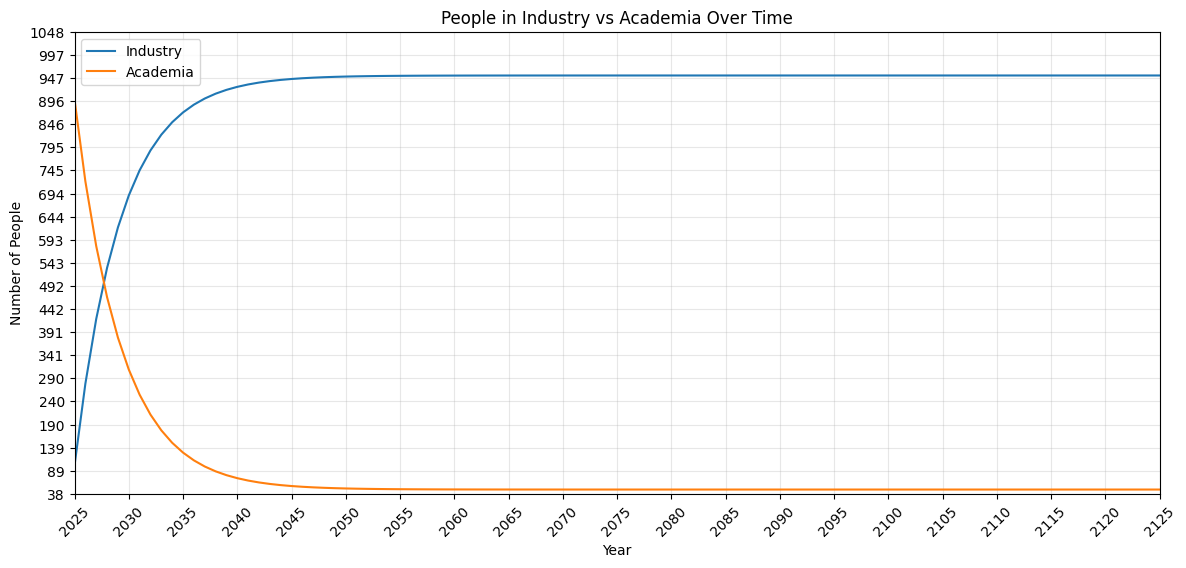

In [55]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(X_axis, Y_axis_industry, label='Industry')
plt.plot(X_axis, Y_axis_academia, label='Academia')

plt.xticks(X_ticks); plt.yticks(Y_ticks)
plt.ylim(Y_min, Y_max); plt.xlim(initialYear, finalYear)

plt.title('People in Industry vs Academia Over Time')
plt.xlabel('Year'); plt.ylabel('Number of People')
plt.xticks(rotation=45)

plt.legend(); plt.grid(alpha=0.3); plt.show()
